# Interpretability of the Image Quality Metrics (IQMs) of MRIQC

MRIQC is a powerful tool to assess the quality of MR images in a research study. In addition to a visual report, a number of image quality metrics (IQMs) is generated. However, there is a large number of these metrics and it is not immediately obvious which IQM a researcher should pay most attention to when deciding over the quality of a given image.

In this notebook, we will explore these issues in the MR-ART dataset, to provide researchers guidance in interpreting and selecting the most important IQMs from MRIQC.

In [7]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots

First, let's import the data. The [Movement-Related Artifacts (MR-ART)](https://openneuro.org/datasets/ds004173) dataset contains the T1-weighted images of 148 healthy subjects (Nárai et al. 2022). Each subject has been acquired under three motion conditions:

1. no head movement
2. little head movement
3. much head movement

The motion was artifically induced by giving the subjects cues when to node their head.

The images were given to two expert raters, who rated the images in their quality, with ratings

1. good quality
2. medium quality
3. bad quality.

What we are interested in here are the IQMs and the ratings scores.

In [12]:
# set path to the data, adjust to where you saved yours
path_data = os.path.abspath("../data/")
# import IQMs
iqms = pd.read_csv(os.path.join(path_data, "IQMs.tsv"), index_col="bids_name", sep="\t")
# import rating scores
scores = pd.read_csv(os.path.join(path_data, "scores.tsv"), index_col="bids_name", sep="\t")
# make sure they are in the same order
iqms.sort_index(inplace=True)
scores.sort_index(inplace=True)

In [25]:
def add_condition_column(scores):
    """Adds a column with the different movement conditions to the rating scores dataframe"""
    stand = scores.index.str.contains("standard")
    hm1 = scores.index.str.contains("motion1")
    hm2 = scores.index.str.contains("motion2")
    conditions = [
        (stand == True),
        (hm1 == True),
        (hm2 == True)]
    choices = [1, 2, 3]
    scores['condition'] = np.select(conditions, choices)
    return scores
scores = add_condition_column(scores)

,score,condition
bids_name,,
sub-000103_acq-headmotion1_T1w,2,2
sub-000103_acq-headmotion2_T1w,3,3
sub-000103_acq-standard_T1w,1,1
sub-000148_acq-headmotion1_T1w,3,2
sub-000148_acq-headmotion2_T1w,3,3
...,...,...
sub-992121_acq-headmotion2_T1w,2,3
sub-992121_acq-standard_T1w,1,1
sub-992238_acq-headmotion1_T1w,3,2


## Rating scores and image conditions

We can explore how well the raters align in their scores with the motion condition. Does their rating reflect how much people moved in the scanner? Let's cross-tabulate them:

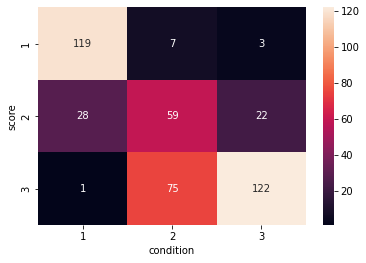

In [14]:
sns.heatmap(pd.crosstab(scores["score"], scores["condition"]), annot=True, fmt=".0f")
plt.show()

We can see that generally there is good correspondance, with most values being on the main diagonal. Most confusion is for score 2, where there are also a lot of images from the no-motion as well as the much motion conditions.

Some images are however completely misclassified. We can visualize this also in a different way to be able to identify the images that were rated much better or much worse than the condition they were in.

In [15]:
px.strip(scores, x="condition", y="score", color=scores.index)

The graphing library `plotly` allows to color the points according to the name of the image, such that we can identify the outliers by hovering over them. We can see that image `sub-613957_acq-standard_T1W` got a bad rating, even though this was the image from the no-motion condition. 

For the three images `sub-253493_acq-headmotion2_T1w`, `sub-257563_acq-headmotion2_T1w`, and `sub-567742_acq-headmotion2_T1w` we have the opposite case: these images got the best rating, even though the subjects were supposed to move their heads a lot during the acquisition of these images.

Try and look at the HTML reports of these images: can you guess what was likely going on in each of these cases?

## Visualizing the IQMs

Next, let's look at the IQMs. There are many different variables here:

In [16]:
iqms.columns

Index(['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
       'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1',
       'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'size_x', 'size_y', 'size_z',
       'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm',
       'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y', 'spacing_z',
       'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean',
       'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95',
       'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad',
       'summary_csf_mean', 'summary_csf_median', 'summary_csf_n',
       'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv',
       'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean',
       'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95',
       'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean',
       'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm

Some of them we can get rid of right away, as they are not image quality metrics, but measurement parameters.

In [17]:
iqms_use = iqms.drop(["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"], axis=1)

We should also normalize the data, as the units of the IQMs vary wildly. This is required by some methods like PCA down the line, but it also makes sense computationally to have all values in the same order of magnitude.

In [39]:
scaler = StandardScaler()
iqms_scaled = scaler.fit_transform(iqms_use)
iqms_scaled = pd.DataFrame(iqms_scaled, columns=iqms_use.columns, index=iqms_use.index)

Also now that we preprocessed our IQMs, let us combine the IQMs, the manual ratings and the motion condition in one dataframe to more easily use it in our analysis

In [40]:
#We merge the dataframes based on their indexes, which corresponds to the bids name of each scan
data_df = pd.merge(left=scores, left_index=True, right=iqms_scaled, right_index=True)
data_df

,score,condition,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
bids_name,,,,,,,,,,,,,,,,,,,,,
sub-000103_acq-headmotion1_T1w,2,2,-0.891671,1.023455,0.379405,0.946453,0.123567,-0.157856,0.347641,0.133998,...,-0.579687,-0.328985,0.664616,0.699918,-0.661274,-0.662092,0.370218,1.094305,0.944828,0.595587
sub-000103_acq-headmotion2_T1w,3,3,0.322492,-0.481170,0.801350,0.170918,-0.342638,-0.669880,-0.226566,-0.081536,...,0.749833,-0.179988,0.977603,-0.253814,0.485443,0.419752,0.458946,0.416501,0.581384,-0.397384
sub-000103_acq-standard_T1w,1,1,-1.198496,1.446902,0.075100,-0.946513,0.006137,-0.202609,0.214003,-0.030905,...,-0.784952,-0.338320,0.498901,0.889660,-0.868823,-0.873470,0.947218,1.395321,0.962421,0.599161
sub-000148_acq-headmotion1_T1w,3,2,0.607133,-0.728387,0.555687,-0.404468,-0.297952,-0.207820,-0.367656,-0.273105,...,0.650114,0.948030,-0.288896,-0.624692,0.642446,0.627561,-1.407102,0.084631,0.058673,-0.062371
sub-000148_acq-headmotion2_T1w,3,3,0.089333,-0.168848,0.483471,0.159432,-0.103982,0.047497,-0.213522,-0.119734,...,0.115257,0.825849,-0.256005,-0.198972,0.161695,0.169568,-1.857269,0.258404,0.227331,0.320730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-992121_acq-headmotion2_T1w,2,3,-0.574475,0.459102,1.106414,0.149363,0.181063,0.342071,0.267109,-0.137932,...,-0.656950,-0.172442,0.747438,0.002640,-0.323392,-0.207552,1.229741,0.334682,-0.199817,-0.725678
sub-992121_acq-standard_T1w,1,1,-1.165106,1.337207,0.707725,-0.946513,0.806795,0.998398,0.969088,0.277350,...,-0.844802,-0.259740,0.359484,0.940510,-0.914859,-0.933136,1.314992,0.870827,-0.036182,-0.299338
sub-992238_acq-headmotion1_T1w,3,2,-0.336329,0.212102,0.022202,0.914001,0.424312,0.288854,0.540691,0.374432,...,0.177875,0.370348,0.767916,-0.232326,0.213313,0.214843,0.473483,0.148033,0.496048,1.543252


Rule number one of data analysis: always visualize your data! We can plot the pairwise scatterplots to get an idea of the relationships between the IQMs. There are quite a few IQMs, so plottings this might take a few minutes, depending on your hardware.

In [20]:
metrics_sets = {f"set{i+1}": list(iqms_scaled.columns[i*10:i*10+9]) for i in range(6)}
metrics_sets["set8"] = list(iqms_scaled.columns[60:])

In [10]:
# for metrics_set in metrics_sets.values():
#     sns.pairplot(iqms_scaled[metrics_set])

Interesting! There are quite a few non-linear relationships between the IQMs, which we should keep in mind should linear dimension reduction techniques fail.
Next, let's do some dimensionality reduction.

## Dimensionality Reduction

### PCA

The simplest dimension reduction technique is principal component analysis (PCA), which projects the data onto a new set of axis defined by the eigenvectors of the data matrix. As the data are already rescaled, we can directly apply it.

In [21]:
# run PCA
pca = PCA()
iqms_pca = pca.fit_transform(iqms_scaled)
col_names_pca = [f"component{i+1}" for i in range(62)]
iqms_pca = pd.DataFrame(iqms_pca, columns=col_names_pca)
# plot PCA
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["condition"])
fig.show()

In [22]:
fig = px.scatter(iqms_pca, x="component1", y="component2", color=scores["score"])
fig.show()

We can see that the first PCA component already separates both the ratings and the conditions quite well.

Here it makes sense to have a look at the loadings to get a sense of which variables contribute most to each component.

In [23]:
loadings = pd.DataFrame(pca.components_[:2].T, index=iqms_scaled.columns)
px.imshow(loadings, color_continuous_midpoint=0, color_continuous_scale=px.colors.diverging.RdBu_r,
width=500, height=1300)#, center=0)

As we can see do the two components capture different information. We already know from the scatterplot that the first component is the one able to separate the conditions/ratings. When looking at the loadings of the first component, we get an idea which of the IQMs influence this component the most. [Here](https://mriqc.readthedocs.io/en/latest/iqms/t1w.html) is an overview of the different measures, that also tells us if higher or lower values indicate a better quality image. E.g., for CJV, lower is better, while for CNR, higher is better. This means that component 1 is related to the "badness" of the image, as the polarity of the loadings of CJV and CNR is opposite to the interpretation of their value.

### t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE) is another dimension reduction technique. Unlike PCA, it also captures non-linear relationships. It is often used for visualization purposes. Let's run t-SNE to get another visualization of the data in latent space:

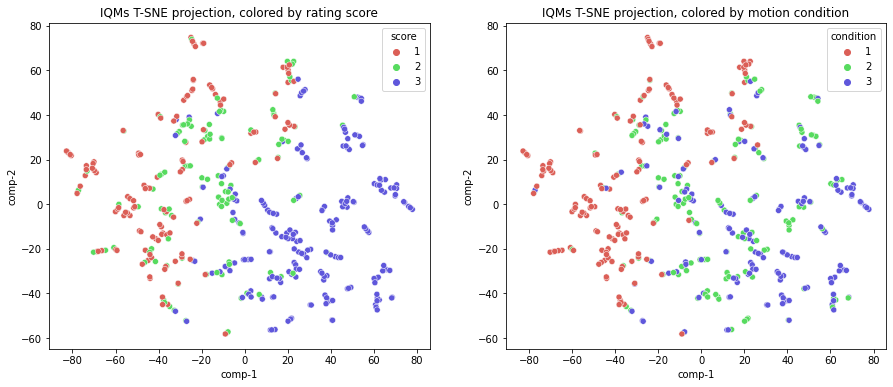

In [24]:
# run TSNE
iqms_embedded = TSNE(n_components=2, learning_rate='auto', init='random' , perplexity=3, random_state=42).fit_transform(iqms_scaled)
# plot TSNE
iqms_embedded = pd.DataFrame(iqms_embedded, columns=["component1", "component2"])
df = pd.DataFrame()
df["score"] = scores["score"].copy()
df["condition"] = scores["condition"].copy()

df["comp-1"] = iqms_embedded["component1"].values
df["comp-2"] = iqms_embedded["component2"].values


fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x="comp-1", y="comp-2", hue="score",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[0]).set(title="IQMs T-SNE projection, colored by rating score")
sns.scatterplot(x="comp-1", y="comp-2", hue="condition",
                palette=sns.color_palette("hls", 3),
                data=df, ax=axs[1]).set(title="IQMs T-SNE projection, colored by motion condition")
plt.show()

While different from the PCA components, the separation does not seem to improve. If anything, it is worse, as now both components are needed to separate images with rating score 1 from those with 2 or 3, instead of just one component when using PCA. The same is true when looking at the movement condition.

## Classification and Feature Importance

While dimension reduction in general and PCA in particular can give us an idea of which IQMs are useful in telling good from bad quality images, a more direct approach is to use the IQMs as features in a classification task.

To make things easier, we will binarize our target: condition/score 1 will be 0, conditions/scores 2 and 3 will be 1.

In [29]:
scores["score_bin"] = np.where(scores["score"] == 1, 0, 1)
scores["condition_bin"] = np.where(scores["condition"] == 1, 0, 1)

### Classification using Support vector machine (SVM)

In [ ]:
svm = LinearSVC(C=0.0625)

### Classification using Elastic-Net

We also try to predict the motion condition based on the IQMs using Elastic-Net (Zou and Hastie 2005) logistic regression. The latter combines L1 and L2 regularization, thus promoting sparsity of the solution which is an advantage for feature selection.

#### Training the model

**Data split**. The first step of any machine learning method is to split the dataset in a train and a test set. The train set will be used to train the model in a cross-validate fashion. The test set will be used to assess prediction accuracy on a set that has not been seen by the model during training.

In [46]:
# Extract the IQMs to serve as features
X = data_df.drop(["score", "condition"], axis=1)
# Extract the motion conditions to serve as labels
y = data_df["condition"] # the only change from model above

#Convert to numpy array
X_np = X.to_numpy()
y_np = y.to_numpy()

#Split the dataset into a train and a test set
X_cv, X_final_test, y_cv, y_final_test = train_test_split(X_np, y_np, test_size=0.1, 
                                                          stratify=y_np, random_state=13)

**Cross-validation.** Next, a stratified 10-fold cross-validation with grid search is performed to optimize the hyperparameters. The train test is further divided into a train and validation set in each fold and the feature coefficients in the decision function are saved in each fold. We will use the latter later to look at the features that are important to perform the prediction.

In [52]:
n_cpus=20
n_folds = 10
# Save accuracy performance and hyper parameter values selected in inner cross-validation
accuracy_perf = {'train': np.zeros(n_folds),
                 'test': np.zeros(n_folds)}
best_hyperparams = {'C': [],
                    'l1_ratio': []}
# Save model parameters at each iteration
lr_params = []
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
# Iterate over each set of folds
for i_fold, (train_ix, test_ix) in enumerate(skf.split(X_cv, y_cv)):
    # test_ix is for our left out fold, and train_ix is from combining all other folds
    X_train, X_test = X_cv[train_ix], X_cv[test_ix]
    y_train, y_test = y_cv[train_ix], y_cv[test_ix]
    # Define the logistic regression using Elastic-Net penalty
    lr = LogisticRegression(penalty='elasticnet', solver='saga',
                                   max_iter=10000, class_weight='balanced')
    # Define the grid search using the previously given names with "dudder" __
    grid_search = GridSearchCV(lr, n_jobs=n_cpus,
                               param_grid={'C': [0.1, 0.5, 1.0, 5.0, 10, 50, 100],
                                           'l1_ratio': np.linspace(0, 1, 11)})
    # Fit as before, but use the grid search object
    grid_search.fit(X_train, y_train)
    # Get performance on training and test set (test set = left out fold)
    best_hyperparams['C'].append(grid_search.best_params_['C'])
    best_hyperparams['l1_ratio'].append(grid_search.best_params_['l1_ratio'])
    best_lr = grid_search.best_estimator_
    print(best_lr)
    accuracy_perf['train'][i_fold] = accuracy_score(y_train, best_lr.predict(X_train))
    accuracy_perf['test'][i_fold] = accuracy_score(y_test, best_lr.predict(X_test))
    # Get model parameters
    lr_params.append(best_lr.coef_[0])

#Save model parameters as a dataframe
lr_params_df = pd.DataFrame(lr_params, columns=X.columns)
lr_params_df

LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.4, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.6000000000000001,
                   max_iter=10000, penalty='elasticnet', solver='saga')
LogisticRegression(class_weight='balanced', l1_ratio=1.0, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.9, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.0, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.4, max_iter=10000,
                   penalty='elasticnet', solver='saga')
LogisticRegression(C=0.5, class_w

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
0,0.000000,0.000000,0.000000,0.052596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.529775,0.000000,0.000000,0.000000,0.00000,0.000000,-0.013138,-1.024274
1,0.000000,0.214545,0.370336,0.162823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.205519,-0.034421,-0.462608,0.000000,-0.112484,-0.076218,0.00000,0.000000,-0.108836,-0.878800
2,0.000000,0.076724,0.273791,0.138417,0.000000,0.000000,0.000000,0.006093,0.000000,0.000000,...,-0.099437,-0.030590,-0.358079,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.841478
3,0.000000,0.000000,0.000000,0.010097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.386596,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.333350
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.066631,-0.407341,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.959045
5,-0.155751,0.286937,0.477723,0.255198,0.034797,-0.145648,0.091090,0.162189,0.030004,0.226111,...,-0.310127,-0.066783,-0.417649,0.210173,-0.260770,-0.244132,-0.03895,-0.026363,-0.352278,-0.647369
6,0.000000,0.243318,0.018781,0.156226,0.030209,0.000000,0.161657,0.190115,0.000000,0.000000,...,-0.154899,-0.000049,-0.305051,0.000000,-0.072277,-0.039116,0.00000,0.000000,-0.187706,-0.805263
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.510598,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.078094
8,-0.103061,0.141179,0.076170,0.002316,0.001971,0.035674,0.010609,0.000000,0.000000,0.090549,...,-0.123653,-0.179050,-0.107761,0.121805,-0.128911,-0.127976,0.00000,0.000000,-0.064951,-0.291618
9,0.000000,0.000000,0.538914,0.160268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.558239,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.209422


**Test on the hold-out test data**. To estimate the final prediction accuracy, we test the model on the hold-out test data and compare it to training accuracy

In [53]:
lr = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000,
                               C=1, l1_ratio=0.7, class_weight='balanced')
lr.fit(X_cv, y_cv)
print(f"Training accuracy: {accuracy_score(y_cv, lr.predict(X_cv))}")
print(f"Hold out dataset test accuracy: {accuracy_score(y_final_test, lr.predict(X_final_test))}")

Training accuracy: 0.8724489795918368
Hold out dataset test accuracy: 0.7954545454545454


#### Visualize model coefficients

Remember that our original question is how to interpret and select the most important IQMs. By looking at the model coefficients, we can discover which features the model found important to predict the motion conditions based on the IQMs.

Like we have seen in this notebook several times, it is important to look at the raw data before analysing them further. Therefore, we plot the model coefficients for each feature in a boxplot.

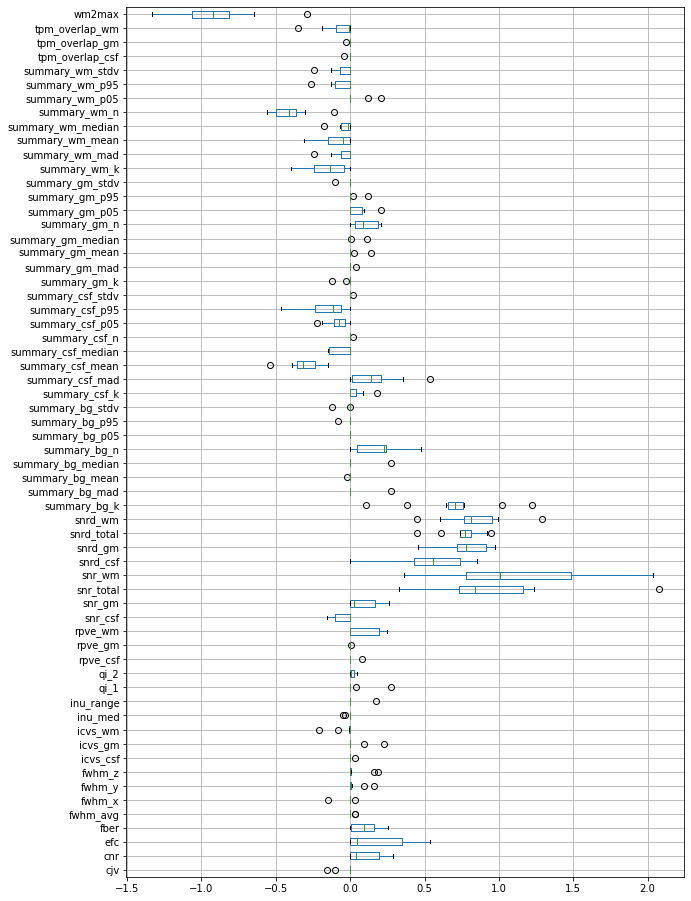

In [54]:
plt.figure(figsize=(10, 16))
lr_params_df.boxplot(vert=False);

The first observation is that many coefficients are zero in many of the splits. This has been enforced by the L1 regularization of the Elastic-Net regression. This is good for us as it reduces number of feature candidates that are important to capture motion artifacts. The second observation is that some IQM seem to be consistently important for the model with their confidence interval not intersecting zero. 

We then summarize model coefficients by extracting their median across the 10-fold cross-validation. The sign of the coefficients is not relevant if we are only interested in the importance for prediction accuracy, so we keep only the absolute value.

In [61]:
#Extract median of model coefficients across 10-fold cross-validation
median_df = pd.DataFrame({"median": lr_params_df.median()})
#Keep only absolute value
median_abs_df = median_df.abs()
median_abs_df

,median
cjv,0.000000
cnr,0.038362
efc,0.047476
fber,0.095507
fwhm_avg,0.000000
...,...
summary_wm_stdv,0.000000
tpm_overlap_csf,0.000000
tpm_overlap_gm,0.000000
tpm_overlap_wm,0.006569


We can now plot the coefficients in a stem plot. Note that to improve its readability, we sort the coefficients first.

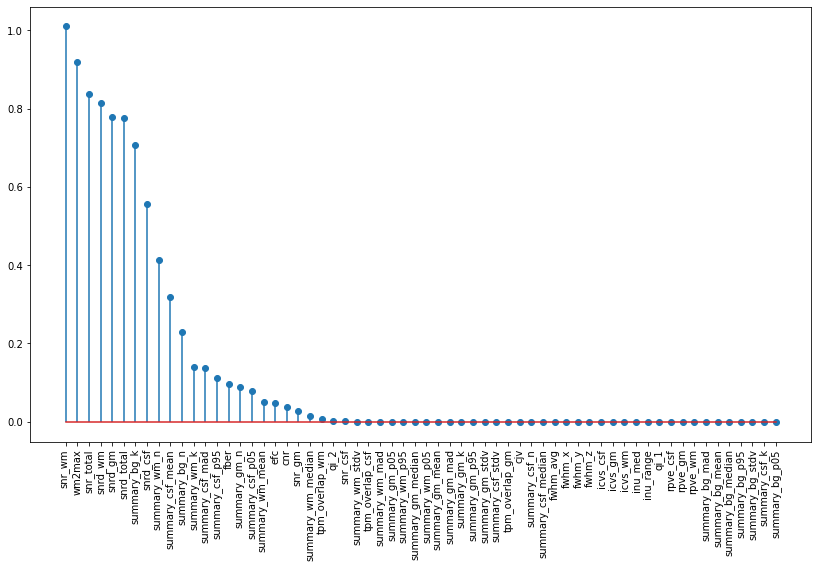

In [64]:
#Sort the coefficients
median_abs_df_sorted = median_abs_df.sort_values(by='median',ascending=False)

#Stem plot
plt.figure(figsize=(14,8))
plt.stem("median", data=median_abs_df_sorted)
plt.xticks(np.arange(len(median_abs_df_sorted)), median_abs_df_sorted.index, rotation='vertical');

Non-surprinsingly, many coefficients have a median of zero as we saw before the that those coefficients are consistently zero across the cross-validation folds. Let's have a look only at the non-zero median features in a polar plot.

In [60]:
#Keep only non-zero median features
median_df_non0 = median_abs_df_sorted[median_abs_df_sorted['median'] != 0]

#Polar plot
radar_lg_df = pd.DataFrame({'r': median_df_non0["median"], 'theta': median_df_non0.index})
radar_lg_df["r_abs"] = radar_lg_df["r"].abs()
plt.figure(figsize=(12,18))
fig = px.line_polar(radar_lg_df, r='r_abs', theta='theta', line_close=True, width=700, height=600)
fig

/home/cprovins/miniconda3/envs/dl/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<Figure size 864x1296 with 0 Axes>

As a conclusion, the most important features to predict motion conditions based on the IQMs are the SNR-derived metrics along with the white matter to maximum intensity ratio (wm2max) and the kurtosis of the background (summary_bg_k).

### Conclusion

Both supervised classification methods give converging evidence that SNR-derived metrics are the most important features to classify motion strength based on the IQMs. Coming back to our original question of interpreting the IQMs, this result means that SNR-derived metrics are capturing motion artifacts. Do not forget that they might be capturing other dimension of image quality as well, but this analysis is not elaborate on that point.

## References

Nárai, Ádám, Petra Hermann, Tibor Auer, Péter Kemenczky, János Szalma, István    Homolya, Eszter Somogyi, Pál Vakli, Béla Weiss, and Zoltán Vidnyánszky. 2022. “Movement-Related Artefacts (MR-ART) Dataset of Matched Motion-Corrupted and Clean Structural MRI Brain Scans.” Scientific Data 9 (1): 630. https://doi.org/10.1038/s41597-022-01694-8.

Zou, Hui, and Trevor Hastie. 2005. “Regularization and Variable Selection via the Elastic Net.” Journal of the Royal Statistical Society: Series B (Statistical Methodology) 67 (2): 301–20. https://doi.org/10.1111/j.1467-9868.2005.00503.x.